The challenge is to classify urban sounds from 4-second sound files. There are 10 possible classifications. The dataset provided includes 8729 training examples and 8731 unlabled sound files for testing. I like this problem because I'm a bit of an audiophile, and I want to try my hand at a neural network. 

I'll train a neural network to classify the sounds. First, I'll use the librosa library to load in the audio files and extract features (the different distinct frequencies in the audio file).  Then, I'll encode the labels using scikit-learn's LabelEncoder().  I'll use Keras to build model, keeping it as simple as possible for now (3 layers, using standard paramaters). Then I will evaluate the model using the test data set.   

##Loading and encoding data. 
I'll install librosa (for dealing with audio files) and import libraries, then load data. 

In [321]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa

In [23]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [24]:
train.head()

,ID,Class
0,0,siren
1,1,street_music
2,2,drilling
3,3,siren
4,4,dog_bark


In [25]:
train.Class.value_counts()

jackhammer          668
engine_idling       624
siren               607
dog_bark            600
street_music        600
air_conditioner     600
drilling            600
children_playing    600
car_horn            306
gun_shot            230
Name: Class, dtype: int64

We have about 600 examples of most sound types, about half that of car horn recordings, and about a third that of gun shots. 

Now we will load the audio files using librosa.  I'll define a function that will allow me to apply the data to a data frame with the IDs and labels. 

Some explanation of the choices for processing audio data: 
1. Setting res_type to kaiser_fast speeds up loading the data, at a loss of quality. 
2. MFCC stands for Mel-frequency cepstral coefficients, it is a technique for extrating features based on frequency from the raw adio data. 
3. librosa.load returns a matrix (technically an mumpy.ndarray of size (n_mfcc, T) where T denotes the track duration in frames).

In [344]:
data_dir = 'data/Train'

def parse_sound(row):

    file_name = os.path.join(data_dir, str(row.ID) + '.wav')

    try:
        y_audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = np.mean(librosa.feature.mfcc(y=y_audio, sr=sample_rate, n_mfcc=40).T,axis=0) 
    except Exception as e:
        print("Error while parsing file: ", file)
        return None
  
    return mfccs

I want to get a visual confirmation of what this function does.  So, 

In [184]:
y_audio, sample_rate = librosa.load(os.path.join('data/Train', '0.wav'))
mfcc = np.mean(librosa.feature.mfcc(y=y_audio, sr=sample_rate, n_mfcc=40).T, axis=0)
mfcc

array([-7.5095695e+01,  1.2961186e+02, -3.2669899e+01,  1.5285441e+01,
       -2.3782072e+00,  1.4626383e+01, -3.7646337e+00,  1.7962053e+01,
       -2.0119922e+00,  1.4395791e+01, -1.1574688e+00,  8.6595840e+00,
       -3.7047443e+00,  3.3922620e+00, -6.3679357e+00,  8.1460260e-02,
       -8.7272234e+00,  6.9419968e-01, -5.4218426e+00,  2.7331510e+00,
       -1.5587350e+00,  1.5997877e+00, -2.7055860e+00,  4.3276987e+00,
       -2.0708835e+00,  4.9955597e+00, -1.8933897e+00, -2.1113320e-01,
       -4.2716827e+00,  1.5992585e+00, -3.1662819e+00,  1.9053738e+00,
       -3.3244791e+00,  8.2804763e-01, -2.8830101e+00,  1.4041675e+00,
       -1.0563265e+00,  1.2371618e+00, -4.3638902e+00,  7.2084457e-01],
      dtype=float32)

These outputs are numerical values for each feature (think of the raw audio as what you hear from a whole choir, and the features are the a representation of each singer's voice for a given time interval, here, 1/10 of a second. It's really pulling out sound waves at different frequencies). 

Numerical values are our input to the ML model! It's just like the numerical representation of light intensity of a given color in a given pixel, in the context of computer vision.  

Join the extracted feature data to the ID and label data. This takes a while... 

In [186]:
ttrain = train
ttrain['mfccs'] = ttrain.apply(parse_sound, axis=1)

In [188]:
ttrain = ttrain[['ID', 'Class', 'mfccs']]
ttrain.head()

,ID,Class,mfccs
0,0,siren,"[-82.12359, 139.50595, -42.430847, 24.82786, -..."
1,1,street_music,"[-15.744001, 124.11996, -29.42888, 39.44719, -..."
2,2,drilling,"[-123.393654, 15.181944, -50.093338, 7.141871,..."
3,3,siren,"[-213.2787, 89.323616, -55.256165, 12.632097, ..."
4,4,dog_bark,"[-237.9265, 135.90247, 39.26844, 21.24023, 9.5..."


unresolved question: are these normally distributed? do they need normalization? do they need regularization? --adress this in next version

Set the mfcc data to X, labels to y, test mfcc data to test_X.  One-hot encode labels using LebelBinarizer. 

In [395]:
from sklearn import preprocessing

X = np.array(ttrain['mfccs'])
# turns out I have to convert this from an array of objects to an array of arrays to have the right shape
X = np.vstack(X)
y = np.array(ttrain['Class'])

# encode labels as numbers
lb = preprocessing.LabelBinarizer()
y = lb.fit_transform(y)
classes = lb.classes_

print('y shape: ', y.shape)
print('y classes detected: ', classes)
print(y[0:5])

y shape:  (5435, 10)
y classes detected:  ['air_conditioner' 'car_horn' 'children_playing' 'dog_bark' 'drilling'
 'engine_idling' 'gun_shot' 'jackhammer' 'siren' 'street_music']
[[0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 0]]


##construct a neural network model!

Notes on hyperparameter choice:
1. 4 layers, one input, two hidden, one output. 
2. Input layer shape is 40 because thre are 40 mel-frequency cepstral coeficients, one for each tenth of a second, in each sound file.  Output layer shape is 10 because there are 10 possible labels (i've one-hot encoded the values).  The hidden layers are set to 100 at start because it seems like a good number? (a next step is to grid search for optimum hyperparameters). 
3. Activation = relu in the first two layers, Activation = softmax for output layer because thats what we need for multi-class classification.  All outputs sum to 1. 
4. Set dropout to 0.2 at start
5. optimizer Adam seems to have good results in the literature. Learning rate defaults to 0.001, which seems good to start. I understand it (roughly) as stochastic gradient desent + a stochastic element based on 

In [371]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

# build model
model = Sequential()

model.add(Dense(100, input_dim=40))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [342]:
baseline = model.fit(X, y, batch_size=32, epochs=100, validation_split=0.2)

Train on 4348 samples, validate on 1087 samples
Epoch 1/100
4348/4348 [==============================] - 0s 47us/step - loss: 0.1216 - accuracy: 0.9637 - val_loss: 0.5888 - val_accuracy: 0.9052
Epoch 2/100
4348/4348 [==============================] - 0s 47us/step - loss: 0.1168 - accuracy: 0.9616 - val_loss: 0.6044 - val_accuracy: 0.9043
Epoch 3/100
4348/4348 [==============================] - 0s 48us/step - loss: 0.1360 - accuracy: 0.9598 - val_loss: 0.5681 - val_accuracy: 0.9025
Epoch 4/100
4348/4348 [==============================] - 0s 54us/step - loss: 0.1363 - accuracy: 0.9595 - val_loss: 0.5429 - val_accuracy: 0.9052
Epoch 5/100
4348/4348 [==============================] - 0s 47us/step - loss: 0.1287 - accuracy: 0.9598 - val_loss: 0.6025 - val_accuracy: 0.8970
Epoch 6/100
4348/4348 [==============================] - 0s 46us/step - loss: 0.1164 - accuracy: 0.9607 - val_loss: 0.6000 - val_accuracy: 0.9025
Epoch 7/100
4348/4348 [==============================] - 0s 48us/step - loss

4348/4348 [==============================] - 0s 47us/step - loss: 0.1249 - accuracy: 0.9627 - val_loss: 0.6325 - val_accuracy: 0.8960
Epoch 57/100
4348/4348 [==============================] - 0s 45us/step - loss: 0.0959 - accuracy: 0.9687 - val_loss: 0.5854 - val_accuracy: 0.9043
Epoch 58/100
4348/4348 [==============================] - 0s 45us/step - loss: 0.1025 - accuracy: 0.9667 - val_loss: 0.6625 - val_accuracy: 0.8970
Epoch 59/100
4348/4348 [==============================] - 0s 44us/step - loss: 0.1279 - accuracy: 0.9618 - val_loss: 0.5459 - val_accuracy: 0.9043
Epoch 60/100
4348/4348 [==============================] - 0s 44us/step - loss: 0.1278 - accuracy: 0.9600 - val_loss: 0.5567 - val_accuracy: 0.9034
Epoch 61/100
4348/4348 [==============================] - 0s 45us/step - loss: 0.1226 - accuracy: 0.9637 - val_loss: 0.5611 - val_accuracy: 0.9071
Epoch 62/100
4348/4348 [==============================] - 0s 44us/step - loss: 0.1176 - accuracy: 0.9671 - val_loss: 0.5714 - val_a

woohooo! 

Ok, now we have to tune the model.  First let's visualize the accuracy as epochs go on, to try select an optimum number of epochs. 

In [330]:
print(baseline.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


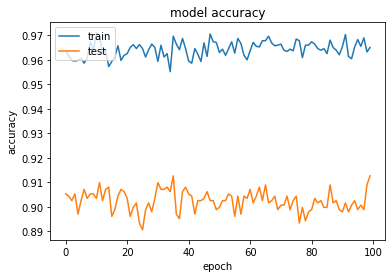

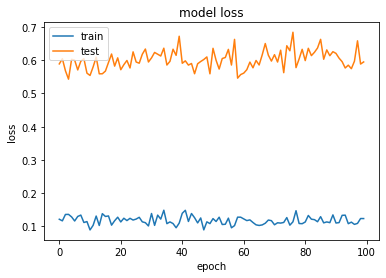

In [343]:
# summarize history for accuracy
plt.plot(baseline.history['accuracy'])
plt.plot(baseline.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(baseline.history['loss'])
plt.plot(baseline.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## train model on full train data set

In [372]:
print(X[0:5])
print(y[0:5])

[[-8.21235886e+01  1.39505951e+02 -4.24308472e+01  2.48278599e+01
  -1.16207657e+01  2.34970875e+01 -1.21945887e+01  2.58971367e+01
  -9.40527439e+00  2.12104378e+01 -7.36882114e+00  1.42543411e+01
  -8.67870235e+00  7.75023842e+00 -1.01241159e+01  3.25811911e+00
  -1.13526201e+01  2.80096865e+00 -7.04601288e+00  3.91331339e+00
  -2.33497453e+00  2.01242232e+00 -2.79394436e+00  4.12927246e+00
  -1.62076902e+00  4.32620049e+00 -1.03440940e+00 -1.23297668e+00
  -3.11085224e+00  3.20448726e-01 -1.78778660e+00  4.42956239e-01
  -1.79164755e+00 -7.63618052e-01 -1.24246442e+00 -2.76640058e-01
   6.57185316e-01 -5.02371192e-01 -2.60428524e+00 -1.05346358e+00]
 [-1.57440014e+01  1.24119957e+02 -2.94288807e+01  3.94471893e+01
  -2.35019169e+01  1.65508118e+01 -2.17368183e+01  1.65335693e+01
  -1.69717293e+01  4.48358440e+00 -1.73876934e+01  7.37121999e-01
  -1.62892284e+01  5.11214876e+00 -1.05592279e+01  2.91787291e+00
  -1.03908472e+01  6.51300132e-01 -1.00463390e+01 -1.78347933e+00
  -6.0997

In [373]:
batch_size = 32
epochs = 100

model.fit(X, y, batch_size=batch_size, epochs=epochs, verbose=0)

## prepare test data and predict

In [363]:
# repeat encoding procedure for the test data

data_dir = 'data/Test'
'''
def parse_sound(row):

    file_name = os.path.join(data_dir, str(row.ID) + '.wav')

    try:
        y_audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = np.mean(librosa.feature.mfcc(y=y_audio, sr=sample_rate, n_mfcc=40).T,axis=0) 
    except Exception as e:
        print("Error while parsing file: ", file)
        return None
  
    return mfccs
'''


# and run on full test data set
test['mfccs'] = test.apply(parse_sound, axis=1)

[-6.75352783e+01  8.07635403e+00 -5.35095453e+00  1.44126701e+01
 -1.11191607e+01  5.43501139e+00 -9.60642529e+00  2.59298396e+00
 -4.13223124e+00 -9.50844228e-01 -8.45531368e+00  7.76937962e+00
 -1.68982372e+01  8.16501236e+00 -1.45517244e+01  3.60345149e+00
 -3.01672565e-03 -4.77612346e-01  9.34465027e+00 -1.60270405e+00
  6.43012285e+00  3.36061549e+00 -3.41992784e+00  7.55481195e+00
 -1.75253022e+00  6.01754618e+00  1.03648686e+00  4.11750031e+00
  4.52184629e+00  9.01627362e-01  1.13913074e-01  4.38824701e+00
 -3.81073308e+00  3.50917459e+00 -9.53719854e-01  8.82968903e-01
 -4.26967955e+00  1.09390020e+00 -5.27148342e+00  4.58460331e+00]


In [364]:
test.head()

,ID,mfccs
0,5,"[-76.2993, 20.437246, -17.56602, 26.38778, -22..."
1,7,"[-375.73608, 149.91734, -21.467178, 14.365269,..."
2,8,"[-150.61726, -26.240969, -24.232021, 15.293082..."
3,9,"[-233.55365, 99.5192, -39.737137, 19.140862, -..."
4,13,"[-74.35853, 107.8869, -15.967571, 34.601448, -..."


In [389]:
X_test = np.array(test['mfccs'])
# convert this from an array of objects to an array of arrays to have the right shape
X_test = np.vstack(X_test)
print(X_test.shape)
print(X_test[0])

(3297, 40)
[-76.2993      20.437246   -17.56602     26.38778    -22.764183
  16.670277   -20.356016    12.797763   -13.740049     8.0202055
 -16.762907    15.398877   -23.84557     14.435516   -20.161507
   8.576482    -4.370316     3.3193154    6.0789685    1.1731479
   4.1006446    5.286643    -4.9847617    8.799       -2.7138798
   6.731223     0.53810346   4.429794     4.368757     0.9185511
   0.21240382   4.192507    -3.5331564    3.1633296   -0.5510365
   0.43360052  -3.782264     0.5759767   -4.7288184    4.023563  ]


In [410]:
preds = model.predict_classes(X_test, verbose=1)

3297/3297 [==============================] - 0s 13us/step


In [426]:
predicted_classes = []
for pred in preds:
    predicted_classes.append(classes[pred])

test['Class'] = predicted_classes

In [427]:
submission = test[['Class', 'ID']]

submission.to_csv('sub01.csv', index=False)

my submission returned about a 0.6 accuracy -- ok but not great (random is around 0.1, and the leaderboard has some scores over 0.9). 

Next steps
- try adding other charateristics of the audio - amplitude-based metrics could plausably help distinguish between kids playing and a jackhammer, for example 
- optimize hyperparamiters using grid search